# Carregar as bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.seterr(divide='ignore', invalid='ignore')
import torchvision
import torchvision.transforms as transforms
import torch
from torch import nn
import torch.nn.functional as F
from datetime import datetime
from torchvision import datasets
from sklearn import preprocessing, metrics, svm
from datetime import datetime

### Base MNIST

In [2]:
def matriz_confusao(y_test, y_pred, labels):
  matriz = metrics.confusion_matrix(y_test, y_pred)
  tot = np.sum(matriz, axis=1, keepdims=True)
  np.set_printoptions(precision=2)
  m_porc = matriz/tot
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m_porc, display_labels=labels)
  disp.plot(values_format='.2f', xticks_rotation='vertical')
  plt.show()

## Definição da rede neural para classificação em Pytorch

In [3]:
def make_layers(cfg, in_channels = 3):
    layers = []
    for v in cfg:
        layers += [nn.Linear(in_channels, v), nn.ReLU()]
        in_channels = v
    return nn.Sequential(*layers)

In [4]:
class Classifier(nn.Module):
    def __init__(self,entrada=4,camadas_escondidas=256 ,saida=3):
        super().__init__()
        self.hidden_layers_num = camadas_escondidas
        self.dense_hidden = make_layers(self.hidden_layers_num, entrada)
        self.fc = nn.Linear(self.hidden_layers_num[-1], saida)

    def forward(self, x):
        x = self.dense_hidden(x)
        x = self.fc(x)
        return x

## Função de treino

In [5]:
def fit(model, criterion, optimizer, train_loader, val_loader, epochs, device="cpu"):
    train_losses = np.zeros( epochs )
    test_losses = np.zeros( epochs )

    for it in range(epochs):
        # Treino
        model.train()
        t0 = datetime.now()
        train_loss = []

        for inputs, targets in train_loader:
            # mover os dados para o GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zerar os gradientes
            optimizer.zero_grad()

            # forward pass
            outputs = model(inputs)

            loss = criterion(outputs, targets)

            # backward pass e optimiza
            loss.backward()
            optimizer.step()

            train_loss.append( loss.item() )
        train_loss = np.mean(train_loss)

        # Validação
        test_loss = []
        for inputs, targets in val_loader:
            model.eval()
            # mover os dados para o GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # salvar losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0

        print(f'Epoch {it+1}/{epochs} Train Loss: {train_loss:.4f} Test Loss: {test_loss} Duracao: {dt}')

    return train_losses, test_losses

## Função de predição

In [6]:
def predict_module(model, test_loader, device="cpu"):
    model.eval()
    predicted = np.empty((0), int)
    true_labels = np.empty((0), int)
    for inputs, targets in test_loader:
        # mover os dados para o GPU, se disponível
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        # obter a predição
        _, predictions = torch.max(outputs, 1)

        predicted = np.append(predicted, predictions.cpu())
        true_labels = np.append(true_labels, targets.cpu())

    return predicted, true_labels

## Plotar a função de perda do treino e teste

In [7]:
def plot_losses(train_losses, test_losses):
    plt.plot(train_losses, label = 'train loss')
    plt.plot(test_losses, label = 'test loss')
    plt.legend()
    plt.show()

# Base de dados

### Datasets & DataLoaders

<p>
Pytorch trabalha com duas abstrações chamadas de Dataset e DataLoader. Elas são responsáveis por alimentar seu treinamento com os dados, fazendo isso de forma bem performática.

As imagens abaixo ilustram muito bem o papel de cada um:

<img src="https://i.imgur.com/KTKptDw.png" alt="redes neurais" style="width: 600px;"/>

<img src="https://i.imgur.com/dhd1XJy.png" alt="redes neurais" style="width: 600px;"/>

</p>

<p>
Na primeira imagem, vemos que o <b>Dataset</b> é responsável por acessar os dados e selecionar um item específico. Portanto, dois métodos são essenciais ao implementar o <b>Dataset</b>:

<ul>
    <li><i>__len__</i>: indica o tamanho do dataset.</li>
    <li><i>__getitem__</i>: coleta um item do dataset.</li>
</ul>
</p>

<p>
Na segunda imagem, observamos o <b>DataLoader</b> em ação, cuja função é solicitar itens específicos ao <b>Dataset</b>. Durante o treinamento, os dados são passados em lotes e embaralhados, fazendo com que os índices solicitados ao <b>Dataset</b> não sigam uma ordem específica.
</p>

<p>
Em termos de implementação, o método <i>__getitem__</i> deve retornar uma tupla contendo o item e o rótulo, seja ele um tensor de imagem, texto, som, etc. Seu trabalho é adaptar os dados brutos para essa estrutura.
</p>

<p>
Em alguns casos, o PyTorch facilita esse processo, eliminando a necessidade de criar uma classe <b>Dataset</b> do zero."
</p>

## Imagens de treino MNIST

In [8]:
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 54.4MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.71MB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 12.2MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.29MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



### Imagens de teste do MNIST

In [9]:
test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform = transforms.ToTensor(),
    download=True
)

## Datalaloader usada para criar batches durante o treino

In [11]:
# Data loader
# Util pq cria automáticamente batches durante o treino
# além de embaralhar os dados
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

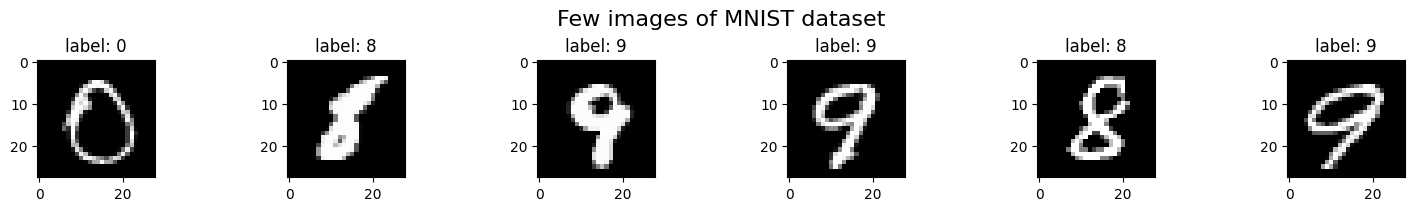

In [12]:
# verificação do funcionamento do dataloader
nb_digits_to_display = 6
f, ax = plt.subplots(1,nb_digits_to_display, figsize=(15,2), constrained_layout=True)
f.suptitle("Few images of MNIST dataset", fontsize=16)
for x, y in train_loader:
  for i in range(nb_digits_to_display):
    ax[i].imshow(x[i].numpy()[-1,:,:], cmap = 'gray')
    ax[i].set_title(f"label: {y[i].numpy()}")
  break

## Questão 1
<p>Implementar uma CNN com as seguinte camadas:</p>
<ul>
<li>1er grupo convolucional:</li>
  <ul>
  <li>Camada convolucional: 20 filtros, tamanho do filtro de $5 \times 5$, stride de 1 e com padding</li>
  <li>Função de ativação: ReLU</li>
  <li>Polling: filtro de $2 \times 2$, stride de 2</li>
  </ul>
<li>2do grupo convolucional:</li>
  <ul>
  <li>Camada convolucional: 50 filtros, tamanho do filtro de $3 \times 3$, stride de 1 e com padding</li>
  <li>Função de ativação: ReLU</li>
  <li>Polling: filtro de $2 \times 2$, stride de 2</li>
  </ul>
<li>3er grupo convolucional:</li>
  <ul>
  <li>Camada convolucional: 50 filtros, tamanho do filtro de $3 \times 3$, stride de 1 e com padding</li>
  <li>Função de ativação: ReLU</li>
  <li>Polling: filtro de $2 \times 2$, stride de 2</li>
  </ul>
<li>Grupo de classificação</li>
  <ul>
  <li>Regularização: dropout de 20%</li>
  <li>Camada fully connected com 400 neuronios</li>
  <li>Função de ativação: ReLU</li>
  <li>Regularização: dropout de 20%</li>
  <li>Camada fully connected com $n$ neuronios, onde $n$ é o número de classes</li>
  </ul>
</ul>

In [13]:
class Minhanet(nn.Module):
    def __init__(self, numChannels, classes):
        # chamar o construtor da classe Base (Pai)
        super(Minhanet, self).__init__()

        # definição das camadas convolucionais
        self.conv_layers = nn.Sequential(
            # primeiro grupo convolucional
            nn.Conv2d(in_channels = numChannels, out_channels=20, kernel_size=5, stride=1, padding = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # segundo grupo convolucional
            nn.Conv2d(in_channels = 20, out_channels=50, kernel_size=3, stride=1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # terceiro grupo convolucional
            nn.Conv2d(in_channels = 50, out_channels=50, kernel_size=3, stride=1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # definiçao das camadas fully connected
        self.dense_layers = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=450, out_features=400),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=400, out_features=classes)
        )
    def forward(self, x):
        # inserir codigo
        out = self.conv_layers(x)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)

        return out


In [14]:
# Instanciar a rede
model = Minhanet(numChannels=1, classes=10)

In [15]:
# modelo carregado na cpu ou gpu (se disponível)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Minhanet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=450, out_features=400, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=400, out_features=10, bias=True)
  )
)

#### Definição da função de perda (custo) e do otimizador

In [16]:
# Loss para varias classes
criterion = nn.CrossEntropyLoss()
# Optimizer
#optimizer = torch.optim.Adagrad( model.parameters() )
optimizer = torch.optim.SGD(model.parameters(),
                                    lr=0.001,
                                    momentum=0.9,
                                    weight_decay=1e-3)

Epoch 1/10 Train Loss: 2.2929 Test Loss: 2.2740074139607103 Duracao: 0:01:32.263478
Epoch 2/10 Train Loss: 2.1000 Test Loss: 1.208040891568872 Duracao: 0:01:32.798373
Epoch 3/10 Train Loss: 0.7649 Test Loss: 0.3345587612896026 Duracao: 0:01:37.576687
Epoch 4/10 Train Loss: 0.3637 Test Loss: 0.19302814642462549 Duracao: 0:01:32.850298
Epoch 5/10 Train Loss: 0.2482 Test Loss: 0.1458307996486561 Duracao: 0:01:32.019124
Epoch 6/10 Train Loss: 0.2009 Test Loss: 0.1236285782313045 Duracao: 0:01:32.735820
Epoch 7/10 Train Loss: 0.1737 Test Loss: 0.10708039302874027 Duracao: 0:01:56.985827
Epoch 8/10 Train Loss: 0.1556 Test Loss: 0.09511264322231276 Duracao: 0:01:34.633323
Epoch 9/10 Train Loss: 0.1401 Test Loss: 0.0868941318520781 Duracao: 0:01:36.848205
Epoch 10/10 Train Loss: 0.1303 Test Loss: 0.07885684866363867 Duracao: 0:01:33.938885


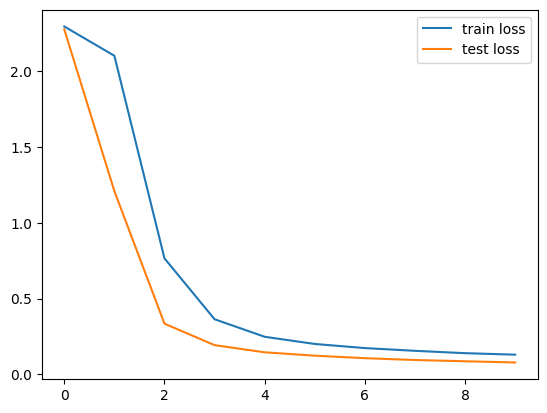

In [17]:
# treino da rede
#(model, criterion, optimizer, train_loader, val_loader, epochs, device="cpu")
epochs = 10
train_losses, val_losses = fit(model, criterion, optimizer, train_loader, test_loader, epochs, device)
plot_losses(train_losses, val_losses)

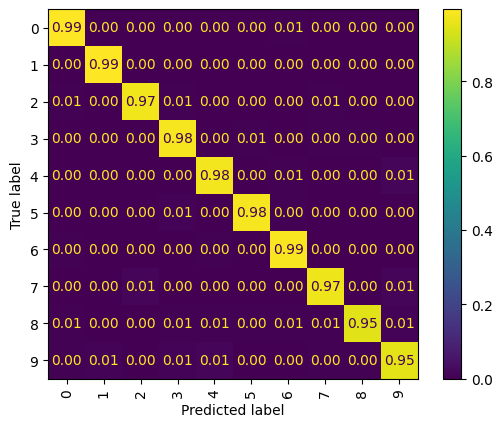

In [18]:
# Avaliando com o conjunto de teste
predicted, true_labels = predict_module(model, test_loader)
labels=['0','1','2','3','4','5','6','7','8','9']
matriz_confusao(true_labels, predicted, labels)

# Questão 2
## Carregar base Fashion MNIST para classificar usando uma CNN

<p>Fashion-MNIST é um conjunto de dados desenvolvido pela Zalando Research como uma alternativa moderna ao conjunto de dados MNIST original. Ele compreende 70.000 imagens em tons de cinza categorizadas em 10 itens relacionados à moda. Cada imagem tem 28×28 pixels, fornecendo um formato uniforme para entrada do modelo de aprendizado de máquina. O conjunto de dados é dividido em um conjunto de treinamento de 60.000 imagens e um conjunto de teste de 10.000 imagens.



<img src="https://media.geeksforgeeks.org/wp-content/uploads/20240514130106/download-(8).png" alt="Drawing"  width="600"/>


As dez categorias no Fashion MNIST são:
<ul>
<li>Camiseta/top</li>
<li>Calça</li>
<li>Pulôver</li>
<li>Vestido</li>
<li>Casaco</li>
<li>Sandália</li>
<li>Camisa</li>
<li>Tênis</li>
<li>Bolsa</li>
<li>Bota de tornozelo</li>
</ul>
</p>

## Carrega o conjunto de treino

In [19]:
train_dataset = torchvision.datasets.FashionMNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.8MB/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 308kB/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.60MB/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 11.9MB/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



## Carrega o conjunto de teste

In [20]:
test_dataset = torchvision.datasets.FashionMNIST(
    root='.',
    train=False,
    transform = transforms.ToTensor(),
    download=True
)

## Implementar a função que particiona o conjunto de treino em treino e validação.
<p> Ver função <i>torch.utils.data.random_split</i> </p>

In [21]:
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

## Crie um Datalaloader para cada subconjunto: treino, validaçao e teste

In [22]:
# Data loader
# Util pq cria automáticamente batches durante o treino
# além de embaralhar os dados
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

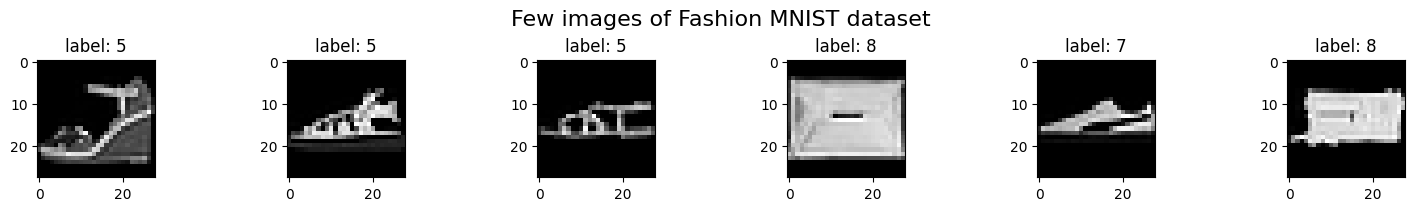

In [23]:
# verificação do funcionamento do dataloader
nb_digits_to_display = 6
f, ax = plt.subplots(1,nb_digits_to_display, figsize=(15,2), constrained_layout=True)
f.suptitle("Few images of Fashion MNIST dataset", fontsize=16)
for x, y in train_loader:
  for i in range(nb_digits_to_display):
    ax[i].imshow(x[i].numpy()[-1,:,:], cmap = 'gray')
    ax[i].set_title(f"label: {y[i].numpy()}")
  break

## <p>Modifique a CNN Minhanet. Deve ser possível passar como parâmetro as camadas que vão realizar o processo de classificação. Para isso, usar a class Classifier definida no inicio deste notebook</p>

In [24]:
class Minhanet2(nn.Module):
    def __init__(self, numChannels, classifier, classes):
        # chamar o construtor da classe Base (Pai)
        super(Minhanet2, self).__init__()

        # definição das camadas convolucionais
        self.conv_layers = nn.Sequential(
            # primeiro grupo convolucional
            nn.Conv2d(in_channels = numChannels, out_channels=20, kernel_size=5, stride=1, padding = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # segundo grupo convolucional
            nn.Conv2d(in_channels = 20, out_channels=50, kernel_size=3, stride=1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # terceiro grupo convolucional
            nn.Conv2d(in_channels = 50, out_channels=50, kernel_size=3, stride=1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # definição das camadas fully connected
        self.dense_layers = classifier
    def forward(self, x):
        # inserir codigo
        out = self.conv_layers(x)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)

        return out

In [25]:
classifier = Classifier(entrada=450, camadas_escondidas=[400], saida=10)
model2 = Minhanet2(numChannels=1, classifier=classifier, classes=10)
# modelo carregado na cpu ou gpu (se disponível)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
# Loss para varias classes
criterion = nn.CrossEntropyLoss()
# Optimizer
#optimizer = torch.optim.Adagrad( model.parameters() )
optimizer = torch.optim.SGD(model2.parameters(),
                                    lr=0.001,
                                    momentum=0.9,
                                    weight_decay=1e-3)

Epoch 1/10 Train Loss: 2.2961 Test Loss: 2.2862519523765465 Duracao: 0:01:21.146507
Epoch 2/10 Train Loss: 2.1800 Test Loss: 1.5516183376312256 Duracao: 0:01:23.504270
Epoch 3/10 Train Loss: 0.9561 Test Loss: 0.8003633991826938 Duracao: 0:01:22.508861
Epoch 4/10 Train Loss: 0.7624 Test Loss: 0.7455867860890641 Duracao: 0:01:22.013012
Epoch 5/10 Train Loss: 0.6989 Test Loss: 0.6521957942956611 Duracao: 0:01:22.765519
Epoch 6/10 Train Loss: 0.6525 Test Loss: 0.6235301056994668 Duracao: 0:01:22.388410
Epoch 7/10 Train Loss: 0.6142 Test Loss: 0.5957260207284855 Duracao: 0:01:21.256937
Epoch 8/10 Train Loss: 0.5867 Test Loss: 0.5806932509699955 Duracao: 0:01:23.264651
Epoch 9/10 Train Loss: 0.5603 Test Loss: 0.5432219422316249 Duracao: 0:01:22.407556
Epoch 10/10 Train Loss: 0.5382 Test Loss: 0.5365810277341287 Duracao: 0:01:22.155331


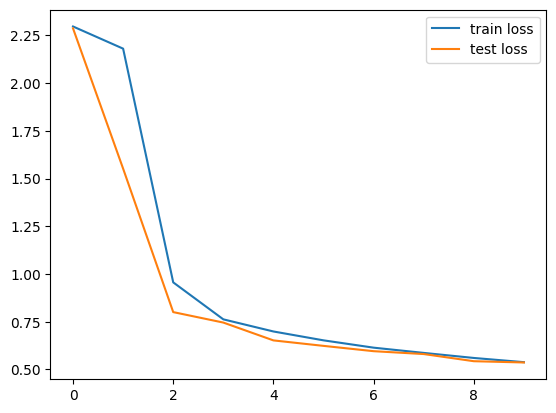

In [27]:
# treino da rede
#(model, criterion, optimizer, train_loader, val_loader, epochs, device="cpu")
epochs = 10
train_losses, val_losses = fit(model2, criterion, optimizer, train_loader, val_loader, epochs, device)
plot_losses(train_losses, val_losses)

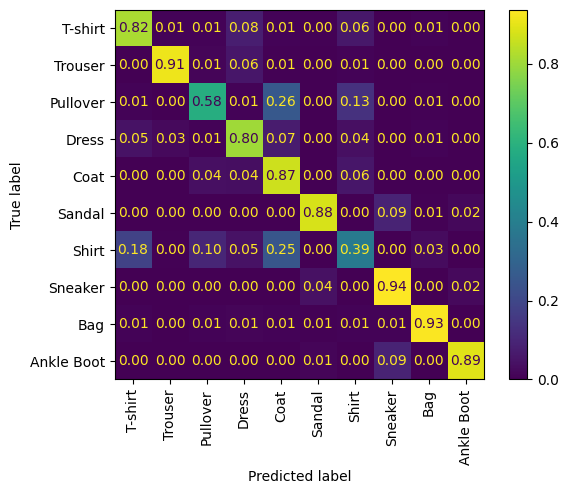

In [28]:
# Avaliando com o conjunto de teste
predicted, true_labels = predict_module(model2, test_loader)
labels=[
    'T-shirt',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle Boot',
]
matriz_confusao(true_labels, predicted, labels)